# Models Exercise 3: Distributed Conceptual Model - FLEXtopo

##### Consider the following FLEXtopo model and the model developed in Exercise 2:

- Make a landscape classification for the Wark catchment, set the HAND threshold to 5m and slope threshold to 11%. 
- Finish the model code for the FLEXtopo model, make sure you use the percentages of the landscape units correctly
- Run also the model developed in exercise 2. Where are the main differences? Which processes are causing this?


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from Weigfun import Weigfun # implemented function
from FLEXtopo import FLEXtopo
from HBVMod import HBVMod, NSE

In [2]:
df = pd.read_csv("wark_data\\forcingWark.txt", delimiter="\t", names=["Date","Q","P","EP"])
df.index = df.apply(lambda x: pd.Timestamp(f'{int(x.Date.split(" ")[0])}-{int(x.Date.split(" ")[1])}-{int(x.Date.split(" ")[2])}'),axis=1)
df.drop(columns=["Date"],inplace=True)
df

,Q,P,EP
2001-08-01,0.09290,0.0,4.002
2001-08-02,0.09086,1.0,4.200
2001-08-03,0.10281,1.5,3.800
2001-08-04,0.10328,1.7,3.000
2001-08-05,0.10178,4.9,2.900
...,...,...,...
2003-07-27,0.09014,2.4,3.602
2003-07-28,0.06749,0.0,3.602
2003-07-29,0.06206,0.0,3.900
2003-07-30,0.08791,11.2,3.500


In [3]:
DEM   = np.genfromtxt('wark_data/dem.asc',    dtype=float, autostrip=True)
slope = np.genfromtxt('wark_data/slope.asc',  dtype=float, autostrip=True)
hand  = np.genfromtxt('wark_data/HAND.asc',   dtype=float, autostrip=True)
basin = np.genfromtxt('wark_data/basin.asc',  dtype=float, autostrip=True)

In [4]:
slope[slope!=-9999]

array([1.36444008, 2.72932363, 4.30904293, ..., 6.26723528, 6.75592995,
       8.84716415])

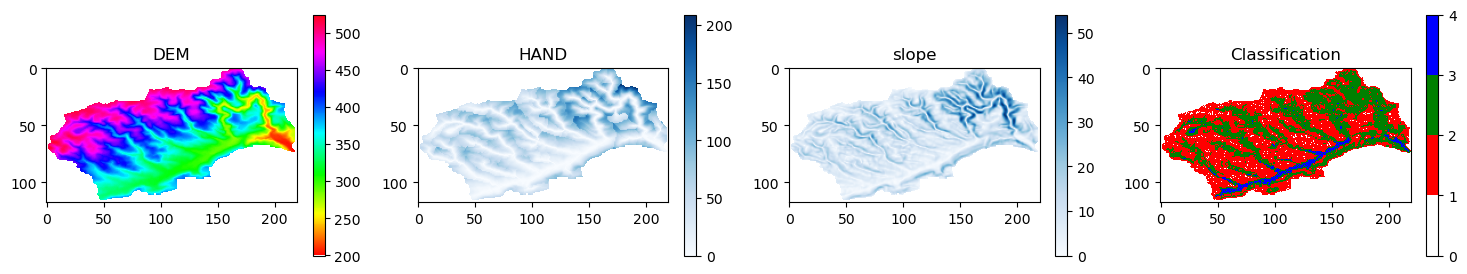

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(15,3))
fig.tight_layout()


# plot DEM
ax[0].set_title("DEM")
DEM[DEM==-9999]=np.nan # deal with nan values
img0 = ax[0].imshow(DEM, cmap='hsv') # plot
plt.colorbar(img0, ax=ax[0])

#plot HAND
ax[1].set_title("HAND")
hand[hand==-9999]=np.nan
img1 = ax[1].imshow(hand, cmap="Blues") # plot
plt.colorbar(img1, ax=ax[1])

#plot slope
ax[2].set_title("slope")
slope[slope==-9999]=np.nan
img2 = ax[2].imshow(slope, cmap="Blues") # plot
plt.colorbar(img2, ax=ax[2])

#make landscape classification
hillslope = (np.array(slope)  >  11) & (np.array(hand)  >  5)
plateau   = (np.array(hand)  >  5)   & (np.array(slope)  <  11) 
wetland   = np.array(hand)   <= 5
basin     = np.array(basin)  >  0
#calculate percentages
hillslope_per = float(np.sum(hillslope)) /np.sum(basin) 
wetland_per   = float(np.sum(wetland))   /np.sum(basin)
plateau_per   = float(np.sum(plateau))   /np.sum(basin)
 

#matrics with landscape classes
landscapes            = np.zeros((118,220))
landscapes[plateau]   = 1
landscapes[hillslope] = 2
landscapes[wetland]   = 3

#plot landscapes
ax[3].set_title("Classification")
cmap = mpl.colors.ListedColormap(['white', 'red', 'green', 'blue'])
bounds=[0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
img3 = ax[3].imshow(landscapes, cmap=cmap, norm=norm)
plt.colorbar(img3,ax=ax[3])

In [6]:
sum([hillslope_per, wetland_per,plateau_per]), hillslope_per, wetland_per,plateau_per

(0.9992439862542954,
 0.4279725085910653,
 0.12577319587628866,
 0.44549828178694156)

# Run model

For each landscape classification, a different parameter set is defined. The parameters ```Ks``` and ```Tlag``` are the same for each classification and therefore defined for the whole catchment.

In [ ]:
                       # Imax  Ce   Sumax  beta  Pmax    Kf  
ParPlateau   = np.array([3.2, 0.50, 17.40, 0.95, 1.94, 0.91])   
                  #      Imax   Ce    Sumax   beta  D   Kf          
ParHillslope = np.array([3.25, 0.50, 321.99, 0.99, 0.4,0.97])
                  #      Imax Ce Sumax beta Cmax     Kf  
ParWetland   = np.array([9.94, 0.50, 53.25, 0.70, 0.65, 0.45])
              # Ks Tlag
ParCatchment = np.array([0.0281, 2.21])

The ```Flextopo``` model needs these parametersets, a DataFrame with forcing and the percentages of each landscape classification. The model returns the modelled discharge. 

In [ ]:
#landscape percentages
landscape_per = np.array([plateau_per, hillslope_per, wetland_per])

df = FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment, df, landscape_per)

In [8]:
Par = np.array([6.15, 0.68, 89.15, 1.85, 0.09, 1.10, 0.1, 0.008])
Sin = [0,0,0,0]
_, df = HBVMod(Par, df, Sin)

In [14]:
NSE("NSE", df['Q'].values, df["Qm"].values), \
NSE("NSE_log", df['Q'].values, df["Qm"].values), \
NSE("NSE_sqrt", df['Q'].values, df["Qm"].values)


C:\Users\david\Documents\@@ Python\Jaar 5\Q3\ENVM1502\Unit 3\Ex4 - distriubted model\HBVMod.py:203: RuntimeWarning: divide by zero encountered in log
  Qm = np.log(Qm)


(0.6633642579181186, -inf, 0.6380219351557515)

<AxesSubplot: >

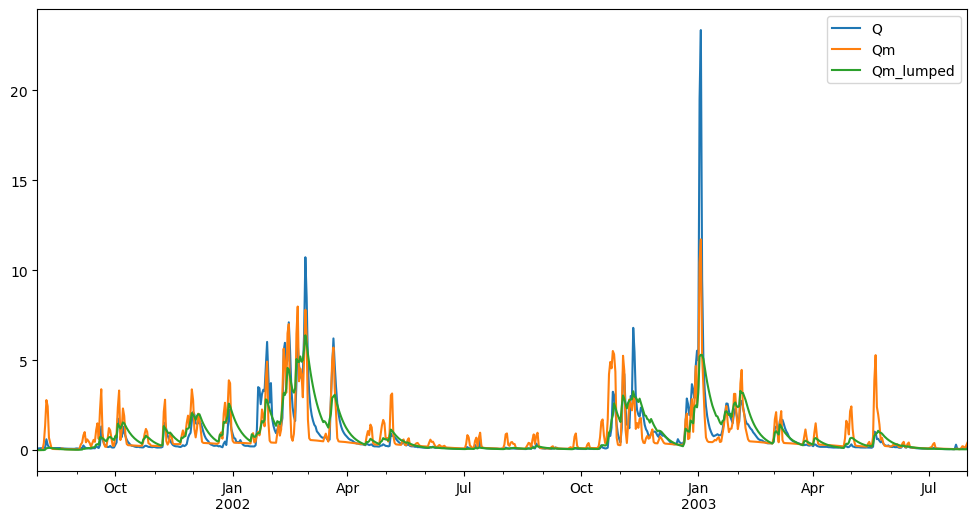

In [15]:
fig, ax = plt.subplots(1, figsize=(12,6))
df[["Q","Qm","Qm_lumped"]].plot(ax=ax)